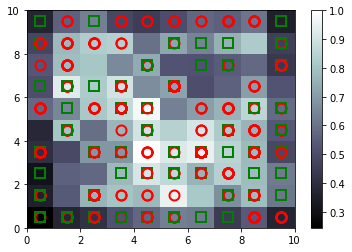

In [70]:
#Part 1 - Identify Frauds with Self Organizing Man

!pip install MiniSom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('Credit_Card_Applications.csv')
#create 2 subsets
#X means: take all line and all columns, except the last one
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

#do normalization
#get features with values between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
#fit sc object to X
X = sc.fit_transform(X)

from minisom import MiniSom
#create an object of the above class
#the training is just done with X, not with y

#first 2 parameters are: 10, 10 (size of the grid)
#then comes input_len (number of features in dataset X)
#sigma: radius of the different neiborhoods in the grid
#learning_rate: how much the weights are updated during each iteration

som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)

#initialize the weights
som.random_weights_init(X)
#specify number of training iterations
som.train_random(data = X, num_iteration = 100)

#the grid will contain the final winning nodes
#for each of these nodes
#we will get the MID (mean interneuron distance)
#the higher the MID, the more far away the node from its neighbors
#high distance means: outlier (most probably fraud)

#the larger the MID, the more white is the box
from pylab import bone, pcolor, colorbar, plot, show
bone()
#get mean distances
#'T' means: get the transpose
pcolor(som.distance_map().T)

#add a legend
colorbar()

#add markers (got approval (green circles) from bank or not (red circles))
#'o' means circle
#'s' means square
markers = ['o', 's']
colors = ['r', 'g']

#loop over all customers
#'i' stands for the indexes (rows) in the database
#'x' stands for the different vectors of each index (customer)
for i, x in enumerate(X):
  #get the winning node of first customer
  w = som.winner(x)
  #place the marker on the winning node
  #w[0] and w[1] are the coordinates of the winning node
  #' + 0.5' puts it in the middle of the square
  plot(w[0] + 0.5,
       w[1] + 0.5,
       #take the info if customer got approval or not
       markers[y[i]],
       #only add color to the edge of the marker
       markeredgecolor = colors[y[i]],
       markerfacecolor = 'None',
       markersize = 10,
       markeredgewidth = 2)
show()



In [53]:
#identify outliers manually/optically
#mappings_1 = som.win_map(X)
#frauds_1 = np.concatenate((mappings_1[(9,2)], mappings_1[(9,3)]), axis=0)
#frauds_1 = sc.inverse_transform(frauds_1)

In [71]:
# Finding the outliers (frauds) (white spots on the SOM)
mappings = som.win_map(X)
arr = np.where(som.distance_map().T>0.95)
zipped = [tuple(t) for t in zip(arr[1],arr[0])]
frauds = []
for i in zipped:
    x = mappings[i]
    if len(x) != 0:
        frauds.append(x)
frauds = np.concatenate(frauds,axis = 0)
frauds = sc.inverse_transform(frauds)

#Part 2 - Going from Unsupervised to Supervised Deep Learning

#create the matrix of features
#we don't need the customerID
#we include last column 'Class' (tells if application was approved or not)
customers = dataset.iloc[:, 1:].values

#create dependent variable 
#--> 1: there was fraud
#--> 0: there was no fraud

#extract the customerIDs of the list 'frauds'
#initialize a vector with 0's 
#we call the independent variable 'is_fraud'
is_fraud = np.zeros(len(dataset))
    
#change those 0's to 1's, where we have customers, who potentially cheated
#all those customerIDs get a 1, that also appear in the fraud list
for i in range(len(dataset)):
  #the 0 relates to the customer column
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

#initialize and train the ANN

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()

#'input_dim' is the number of features
classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim=15))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#fitting ANN to Training set
#'is_fraud' is our dependent variable
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)

#predict probabilities of frauds
#for each customer, we predict the probability that the customer cheated
#with its application
y_pred = classifier.predict(customers)

#add the customer IDs to the prediction array
#the expression '0:1' selects the customerID but also changes the array from a 1D to a 2D array
#axis=1 will make a horizontal concatenation
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis=1)

#sort customers according to their cheating probability
y_pred = y_pred[y_pred[:,1].argsort()]
y_pred

Epoch 1/2
690/690 [==============================] - 1s 977us/step - loss: 0.5782 - accuracy: 0.9772
Epoch 2/2
690/690 [==============================] - 1s 1ms/step - loss: 0.1368 - accuracy: 0.9902


array([[1.56548590e+07, 5.31232357e-03],
       [1.57250280e+07, 6.37501478e-03],
       [1.57238270e+07, 6.88353181e-03],
       ...,
       [1.57257760e+07, 1.48548037e-01],
       [1.57363990e+07, 1.64900392e-01],
       [1.57901130e+07, 3.31932425e-01]])